In [111]:
import numpy as np
import pandas as pd

#Feature Description
#CensusTract, SchoolYear, GradeLevel, Count given from DOE. SchoolYear 0 means Grade K

###Added features###
#TotalCount = Total number of students for a given year across all tract and grade
#TotalCountByGrade = Total number of students for a given year and grade across all tract
#TotalCountByTract = Total number of students for a given year and tract across all grade
#TotalCountByZip = Total number of studetns for a given year and zip across all grade
#TotalCountByZipGrade = Total number of students for a given year, zip and grade
#TotalCountByTractGrade = Same as Count // can be removed
#PrevGradeCount = Total number of students from prior grade for a given yaer and tract
#e.g, for year 2010, tract 18, grade 5, its PrevGradeCount will be Count from year 2010, tract 18 and grade 4
#PrevGradeCountmavg3 = 3 year average of PrevGradeCount
#PrevGradeCountmavg5 = 5 year average of PreveGradeCount
#OneYearGrowth = one year growth rate of Count for a given tract and grade
#ThreeYearGrowth = three year growth rate of Count for a given tract and grade
#OneYearGrowthmavg3 = 3 year average of OneYearGrowth
#ThreeYearGrowthmavg3 = 3 year average of ThreeYearGrowth
#Y = Target variable 1 = Increase in count in the next year, 0 = decrease/stay the same in the next year

##We can ignore Target,Y2 columns in newt.csv // I will clean up later
df = pd.read_csv('cleantable-mb.csv')
df = df[df.SchoolYear<2010]
df = df.drop(['CensusTract','GradeLevel','Target','Y2','LongTract','Zip','NextYearCount','TotalCountByTractGrade'],axis=1) #exclude some columns
test_df = df[df.SchoolYear>2007] #Test set 2008, 2009
train_df = df[df.SchoolYear<=2007] # Training set from 2001 to 2007
df.head()

,SchoolYear,Count,TotalCount,TotalCountByGrade,TotalCountByTract,TotalCountByZip,TotalCountByZipGrade,PrevGradeCount,PrevGradeCountmavg3,PrevGradeCountmavg5,OneYearGrowth,ThreeYearGrowth,OneYearGrowthmavg3,ThreeYearGrowthmavg3,Y,neighborCount,neighborThreeYearGrowthmavg3,neighborThreeYearGrowth
0,2001,0,16345,2702,1,3382,562,0,0,0,0.0,0.0,0.00000,0.0,0,24,0.00000,0.0
1,2002,0,16334,2613,1,3329,525,0,0,0,0.0,0.0,0.00000,0.0,1,42,0.00000,0.0
2,2003,1,16266,2546,3,3277,519,0,0,0,0.0,0.0,0.00000,0.0,0,30,0.00000,0.0
3,2004,0,16081,2606,2,3191,535,0,0,0,-1.0,0.0,-0.33333,0.0,0,18,-0.49998,-1.5
4,2005,0,15892,2615,2,3148,537,0,0,0,0.0,0.0,-0.33333,0.0,0,42,-0.49998,0.0


In [112]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

train_df_x = train_df.drop('Y',1)
train_df_y = train_df.Y
test_df_x = test_df.drop('Y',1)
test_df_y = test_df.Y

clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(train_df_x, train_df_y)

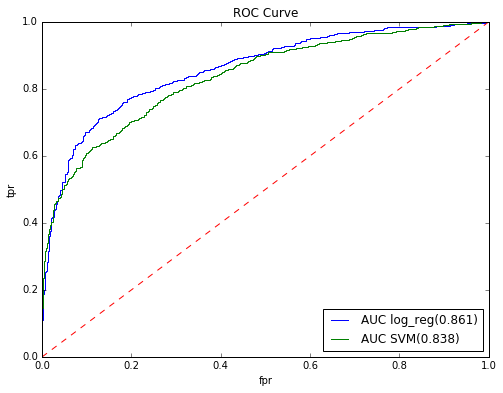

In [135]:
from sklearn import linear_model, metrics, svm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

logreg = linear_model.LogisticRegression(C = 1e30)
logreg.fit(train_df_x, train_df_y)
pred_lr = logreg.predict_proba(test_df_x)[:,1]

fpr_lr, tpr_lr, thre_lr = metrics.roc_curve(test_df_y, pred_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

my_svm = svm.SVC(kernel='linear')
my_svm.fit(train_df_x, train_df_y)
pred_svm = my_svm.decision_function(test_df_x)

fpr_svm, tpr_svm, thre_svm = metrics.roc_curve(test_df_y, pred_svm)
roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)

fig = plt.figure(figsize = (8, 6))
plt.title('ROC Curve')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'r--', label='')
plt.plot(fpr_lr, tpr_lr, label='AUC log_reg({0:.3f})'.format(roc_auc_lr))
plt.plot(fpr_svm, tpr_svm, label='AUC SVM({0:.3f})'.format(roc_auc_svm))
plt.legend(loc=4)

In [133]:

from sklearn.metrics import confusion_matrix, roc_auc_score

c_s = [ -3, 0.5, 1, 5, 10, 20, 30] 
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag']

# We will want to keep track of some different roc curves, lets do that here
tprs = []
fprs = []
roc_labels = []

for s in solver:
    for c in c_s:

        logreg = linear_model.LogisticRegression(C=10**c,solver=s,penalty='l2',max_iter=1000)
        logreg.fit(train_df_x, train_df_y)

        fpr, tpr, thresholds = metrics.roc_curve(test_df_y, logreg.predict_proba(test_df_x)[:,1])
        tprs.append(tpr)
        fprs.append(fpr)
        
        roc_labels.append(s + " - L2 - " + str(c) + ": %.3f" % metrics.roc_auc_score(logreg.predict(test_df_x),  test_df_y))

        if c in aucs:
            aucs[c].append(roc_auc_lr)
        else:
            aucs[c] = [roc_auc_lr]
for c in c_s:
    logreg = linear_model.LogisticRegression(C=10**c,solver='liblinear',penalty='l1',max_iter=1000)
    logreg.fit(train_df_x, train_df_y)

    fpr, tpr, thresholds = metrics.roc_curve(test_df_y, logreg.predict_proba(test_df_x)[:,1])
    tprs.append(tpr)
    fprs.append(fpr)
    roc_labels.append("liblinear - L1 -" + str(c) + ": %.3f" % metrics.roc_auc_score(logreg.predict(test_df_x),  test_df_y))

    if c in aucs:
        aucs[c].append(roc_auc_lr)
    else:
        aucs[c] = [roc_auc_lr]
    

C:\SourceCode\Python\lib\site-packages\scipy\optimize\linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\SourceCode\Python\lib\site-packages\scipy\optimize\linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\SourceCode\Python\lib\site-packages\sklearn\utils\optimize.py:193: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\SourceCode\Python\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


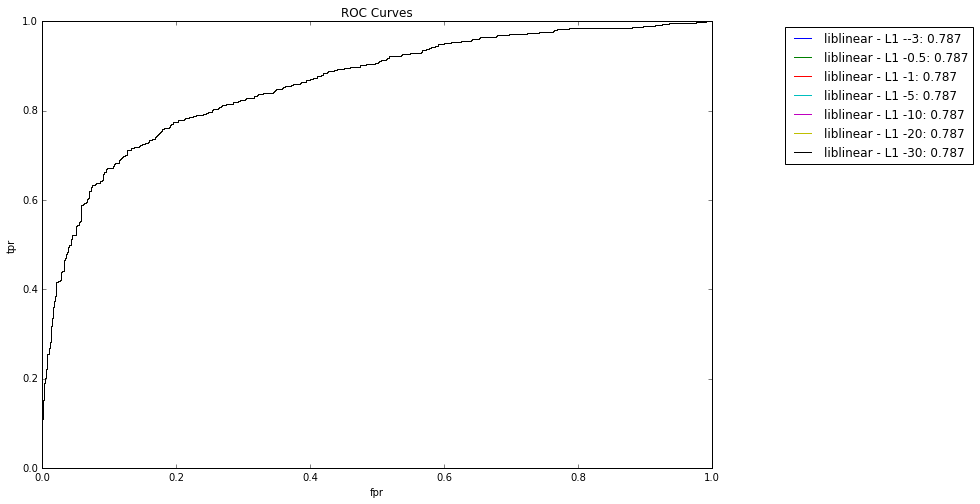

In [131]:

fig = plt.figure(figsize = (12, 8))

for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)
    
plt.title('ROC Curve')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()
plt.legend(bbox_to_anchor=(1.25,1), loc='upper center', ncol=1)
plt.show()

In [104]:
L2 = {}
L1 = {}

for i in c_s:
    LR2 = linear_model.LogisticRegression(C=10**i, penalty = 'l2',solver='liblinear')
    LR2.fit(train_df_x, train_df_y)
    L2[i] = LR2.coef_[0]
    LR1 = linear_model.LogisticRegression(C=10**i, penalty = 'l1',solver='liblinear')
    LR1.fit(train_df_x, train_df_y)
    L1[i] = LR1.coef_[0]
    
feats = train_df_x.columns.values
Rpath2 = pd.DataFrame(L2, index=feats).transpose()
Rpath1 = pd.DataFrame(L1, index=feats).transpose()

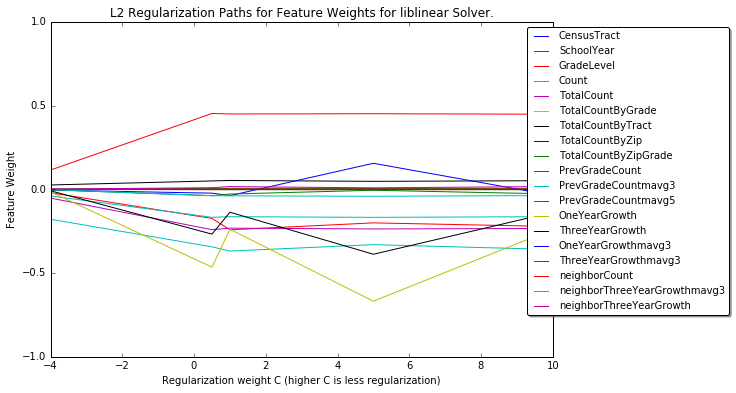

In [107]:
plt.clf()
fig = plt.figure()
ax = plt.subplot(111)

for f in feats:
    plt.plot(Rpath2.index.values, Rpath2[[f]], label=f)
    

plt.xlim([-4, 10])
plt.ylim([-1, 1])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*1.5, box.height * 1.5])

    # Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(1.15, 1), fancybox=True, shadow=True, ncol=1, prop={'size':10})

plt.title('L2 Regularization Paths for Feature Weights for liblinear Solver.')
plt.xlabel('Regularization weight C (higher C is less regularization)')
plt.ylabel('Feature Weight')
plt.show()

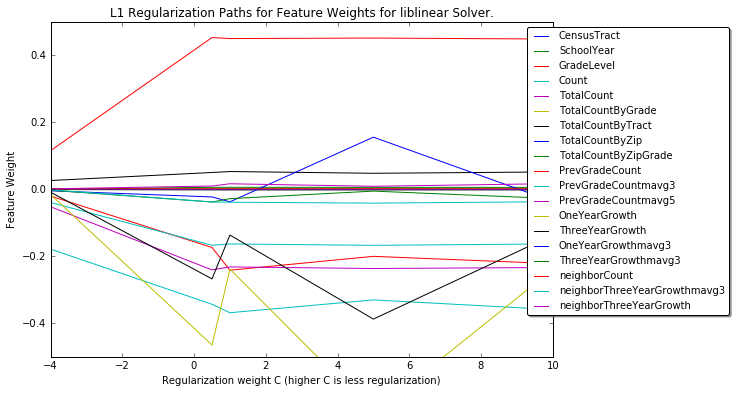

In [109]:
plt.clf()
fig = plt.figure()
ax = plt.subplot(111)

for f in feats:
    plt.plot(Rpath1.index.values, Rpath2[[f]], label=f)

plt.xlim([-4, 10])
plt.ylim([-0.5, 0.5])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*1.5, box.height * 1.5])

    # Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(1.15, 1), fancybox=True, shadow=True, ncol=1, prop={'size':10})

plt.title('L1 Regularization Paths for Feature Weights for liblinear Solver.')
plt.xlabel('Regularization weight C (higher C is less regularization)')
plt.ylabel('Feature Weight')
plt.show()